# Import libraries

In [14]:

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

!pwd

/nfs/u50/zhanh279/SemEval-2026/subTask1


# DATA LOADING & PREPARATION

In [15]:
test_embeddings=pd.read_pickle('data/task1_embedding_test.pickle')

test_sims=pd.read_pickle('data/test+sim.pickle')

test_LIWC=pd.read_pickle("data/task1_LIWC_test.pickle")

# Data preparation: combine all features (LIWC + Embedding + Sims + is_words + token_num + feeling_rep + User embedding)

In [16]:

# Data preparation: combine all features (LIWC + Embedding + Sims + is_words + token_num + feeling_rep + User embedding)

# Load target data
test_targets = pd.read_pickle("data/test.pickle")

# Load scalers and vocab (saved by full_baseline.ipynb)
scaler_liwc  = pickle.load(open("scaler_liwc.pkl",  "rb"))
scaler_sim   = pickle.load(open("scaler_sim.pkl",   "rb"))
scaler_token = pickle.load(open("scaler_token.pkl", "rb"))
feeling_data = pickle.load(open("feeling_vocab.pkl", "rb"))
feeling_word2idx  = feeling_data['word2idx']
FEELING_VOCAB_SIZE = len(feeling_data['vocab'])

# Reset indices for alignment
test_sims       = test_sims.reset_index(drop=True)
test_LIWC       = test_LIWC.reset_index(drop=True)
test_embeddings = test_embeddings.reset_index(drop=True)
test_targets    = test_targets.reset_index(drop=True)

# Extract user IDs
test_user_ids = test_targets['user_id'].values

# Extract LIWC features (numeric columns only, skip metadata and targets)
exclude_cols = ['user_id', 'text_id', 'valence', 'arousal', 'collection_phase', 'is_words', 'num_tokens', 'is_seen_user']
liwc_feature_cols = [col for col in test_LIWC.columns if col not in exclude_cols and col not in ['text', 'timestamp', 'text_tokens', 'text_liwc_tokens']]
test_liwc_features = test_LIWC[liwc_feature_cols].values.astype(float)

# ---- Length normalization (must match training preprocessing) ----
test_num_tokens    = test_LIWC['num_tokens'].values.astype(float).clip(min=1).reshape(-1, 1)
test_liwc_features = test_liwc_features / test_num_tokens          # raw counts → proportions
test_log_len       = np.log1p(test_num_tokens)                     # log(num_tokens) feature
test_liwc_features = np.hstack([test_liwc_features, test_log_len]) # append log_len
# ------------------------------------------------------------------

# Apply LIWC scaler (transform only, NOT fit_transform)
test_liwc_features = scaler_liwc.transform(test_liwc_features)

# Embedding features - no scaler (matches training)
test_emb_features = np.array([np.array(x) for x in test_embeddings['embedding'].values])

# Sim features
sim_cols = [col for col in test_sims.columns if 'sim' in col.lower()]
test_sim_features = test_sims[sim_cols].values.astype(float)
test_sim_features = scaler_sim.transform(test_sim_features)

# ---- is_words feature (True=1, False=0) ----
test_is_words = test_LIWC['is_words'].values.astype(int).reshape(-1, 1)

# ---- token_num: count tokens in 'text' column ----
def _count_tokens(liwc_df):
    texts     = liwc_df['text'].astype(str).values
    is_w_mask = liwc_df['is_words'].astype(bool).values
    counts_words  = np.array([len([w for w in t.split(',') if w.strip()]) for t in texts[is_w_mask]])
    counts_essays = np.array([len(t.split()) for t in texts[~is_w_mask]])
    result = np.empty(len(texts), dtype=float)
    result[is_w_mask]  = counts_words
    result[~is_w_mask] = counts_essays
    return np.maximum(result, 1).reshape(-1, 1)

_test_tok_raw = _count_tokens(test_LIWC)
test_token_num = scaler_token.transform(np.log1p(_test_tok_raw))  # transform only

# ---- feeling_words_rep: multi-hot using training vocabulary ----
def _encode_feeling(liwc_df, word2idx, vocab_size):
    """Multi-hot for is_words=True rows; zero vector for is_words=False."""
    n            = len(liwc_df)
    mat          = np.zeros((n, vocab_size), dtype=np.float32)
    is_words_arr = liwc_df['is_words'].astype(bool).values
    texts        = liwc_df['text'].values
    for i, (is_w, txt) in enumerate(zip(is_words_arr, texts)):
        if is_w:
            for w in [x.strip().lower() for x in str(txt).split(',') if x.strip()]:
                if w in word2idx:
                    mat[i, word2idx[w]] = 1.0
    return mat

test_feeling_rep = _encode_feeling(test_LIWC, feeling_word2idx, FEELING_VOCAB_SIZE)

print(f"\nFeature dimensions:")
print(f"  LIWC (length-normalised + log_len): {test_liwc_features.shape[1]}")
print(f"  Embedding: {test_emb_features.shape[1]}")
print(f"  Sims: {test_sim_features.shape[1]}")
print(f"  is_words: 1")
print(f"  token_num: 1")
print(f"  feeling_words_rep (multi-hot): {FEELING_VOCAB_SIZE}")
feat_dim = test_liwc_features.shape[1] + test_emb_features.shape[1] + test_sim_features.shape[1] + 1 + 1 + FEELING_VOCAB_SIZE
print(f"  --- X_test_tensor dim (before user emb): {feat_dim}")
print(f"  User embedding: 32 (concatenated at inference time)")
print(f"  Total model input dim: {feat_dim + 32}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Combine all features (must match training order exactly)
X_test_full = np.hstack([test_liwc_features, test_emb_features, test_sim_features,
                          test_is_words, test_token_num, test_feeling_rep])

# Load training user_id_map (DO NOT rebuild)
train_user_id_map = pickle.load(open("Baselines/user_id_map.pkl", "rb"))
print(f"\nLoaded training user_id_map with {len(train_user_id_map)} users")

test_is_seen_user = test_targets['is_seen_user'].values
num_seen   = test_is_seen_user.sum()
num_unseen = len(test_is_seen_user) - num_seen
print(f"\nTest set user distribution:")
print(f"  Seen users (in training): {num_seen}")
print(f"  Unseen users (new): {num_unseen}")
print(f"  Total test samples: {len(test_user_ids)}")

# Convert to tensor
X_test_tensor = torch.tensor(X_test_full, dtype=torch.float32).to(device)

print(f"\nTensor shapes:")

print(f"  X_test: {X_test_tensor.shape}")


Feature dimensions:
  LIWC (length-normalised + log_len): 80
  Embedding: 384
  Sims: 10
  is_words: 1
  token_num: 1
  feeling_words_rep (multi-hot): 306
  --- X_test_tensor dim (before user emb): 782
  User embedding: 32 (concatenated at inference time)
  Total model input dim: 814

Using device: cuda

Loaded training user_id_map with 137 users

Test set user distribution:
  Seen users (in training): 692
  Unseen users (new): 1045
  Total test samples: 1737

Tensor shapes:
  X_test: torch.Size([1737, 782])


In [17]:
# ============================================================================
# PART 2: MODEL DEFINITION & LOADING
# ============================================================================

# Define MLPModel class (must match the training model)
class MLPModel(nn.Module):
    def __init__(self, feature_dim=505, num_users=1000, user_embedding_dim=32, hidden_dim=512):
        super(MLPModel, self).__init__()
        
        # User embedding
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = features + user embedding
        input_dim = feature_dim + user_embedding_dim
        
        # MLP layers: [input → 512 → 256 → 128 → 2]
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, 2)  # Predict valence and arousal
        
    def forward(self, x_features, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)
        
        # Concatenate features and user embedding
        combined = torch.cat([x_features, user_embed], dim=1)
        
        # MLP layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

# Load the best model
print("\n" + "=" * 70)
print("STEP 2: LOAD PRE-TRAINED MODEL")
print("=" * 70)

# Initialize with the exact number of users from training
num_training_users = len(train_user_id_map)
model = MLPModel(feature_dim=X_test_tensor.shape[1], num_users=num_training_users, 
                 user_embedding_dim=32, hidden_dim=512)
model = model.to(device)
model.load_state_dict(torch.load("Baselines/best_model.pt", map_location=device, weights_only=True))
model.eval()

print("✓ Model loaded successfully")
print(f"Model trained with {num_training_users} users")
print(f"Model architecture: {X_test_tensor.shape[1]} features + 32 user embedding → 512 → 256 → 128 → 2")



STEP 2: LOAD PRE-TRAINED MODEL
✓ Model loaded successfully
Model trained with 137 users
Model architecture: 782 features + 32 user embedding → 512 → 256 → 128 → 2


# EXTRACT TRAINED USER EMBEDDINGS

In [18]:
# Get the trained user embedding layer
trained_user_embeddings = model.user_embedding.weight.data.cpu().numpy()
print(f"Trained user embeddings shape: {trained_user_embeddings.shape}")
print(f"User embedding dimension: {trained_user_embeddings.shape[1]}")

# Save the embeddings for potential future use
np.save("Baselines/trained_user_embeddings.npy", trained_user_embeddings)
print(f"✓ Saved trained user embeddings")



# Get is_seen_user information from test data
test_is_seen_user = test_targets['is_seen_user'].values

# Create user embedding matrix for test samples
user_embedding_dim = 32
test_user_embeddings = np.zeros((len(test_user_ids), user_embedding_dim), dtype=np.float32)

seen_count = 0
unseen_count = 0

for i, (uid, is_seen) in enumerate(zip(test_user_ids, test_is_seen_user)):
    if is_seen and uid in train_user_id_map:
        # User was in training data - use trained embedding
        embedding_idx = train_user_id_map[uid]
        test_user_embeddings[i] = trained_user_embeddings[embedding_idx]
        seen_count += 1
    else:
        # New user not in training - use zero vector
        test_user_embeddings[i] = np.zeros(user_embedding_dim, dtype=np.float32)
        unseen_count += 1

print(f"\nUser embedding results:")
print(f"  Users with trained embeddings (is_seen=True): {seen_count}")
print(f"  Users with zero embeddings (is_seen=False or not in map): {unseen_count}")
print(f"  Total: {len(test_user_ids)}")

# Convert to tensor
test_user_embeddings_tensor = torch.tensor(test_user_embeddings, dtype=torch.float32).to(device)
print(f"\n✓ User embeddings tensor shape: {test_user_embeddings_tensor.shape}")


Trained user embeddings shape: (137, 32)
User embedding dimension: 32
✓ Saved trained user embeddings

User embedding results:
  Users with trained embeddings (is_seen=True): 692
  Users with zero embeddings (is_seen=False or not in map): 1045
  Total: 1737

✓ User embeddings tensor shape: torch.Size([1737, 32])


# Make predictions on test data with pre-extracted user embeddings

In [19]:
model.eval()
with torch.no_grad():
    # Manually forward pass: combine features with pre-extracted user embeddings
    combined = torch.cat([X_test_tensor, test_user_embeddings_tensor], dim=1)
    
    # Pass through MLP layers
    x = model.fc1(combined)
    x = model.relu(x)
    x = model.dropout(x)
    x = model.fc2(x)
    x = model.relu(x)
    x = model.dropout(x)
    x = model.fc3(x)
    x = model.relu(x)
    x = model.dropout(x)
    test_predictions = model.fc4(x)

# Convert predictions to numpy
test_preds_np = test_predictions.cpu().numpy()

print(f"\nPredictions shape: {test_preds_np.shape}")
print(f"Sample predictions (first 5):")
print(f"  Valence: {test_preds_np[:5, 0]}")
print(f"  Arousal: {test_preds_np[:5, 1]}")

# Create results DataFrame
results_df = pd.DataFrame({
    'user_id': test_user_ids,
    'text_id': test_targets['text_id'].values,
    'pred_valence': test_preds_np[:, 0],
    'pred_arousal': test_preds_np[:, 1]
})

print(f"\nResults DataFrame shape: {results_df.shape}")
print(f"Results head:\n{results_df.head()}")

# Save to CSV
output_file = "pred_subtask1.csv"
results_df.to_csv(output_file, index=False)
print(f"\n✓ Predictions saved to {output_file}")



Predictions shape: (1737, 2)
Sample predictions (first 5):
  Valence: [ 0.87129927  0.8981688   1.3458081   1.1240983  -0.28155777]
  Arousal: [0.61001754 0.93353724 0.90729094 0.82309496 0.6435457 ]

Results DataFrame shape: (1737, 4)
Results head:
   user_id  text_id  pred_valence  pred_arousal
0        3      256      0.871299      0.610018
1        3      257      0.898169      0.933537
2        3      258      1.345808      0.907291
3        3      249      1.124098      0.823095
4        3      250     -0.281558      0.643546

✓ Predictions saved to pred_subtask1.csv


# Visualization of predictions distribution

/tmp/ipykernel_1400712/1274348467.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data, labels=['Valence', 'Arousal'], patch_artist=True)


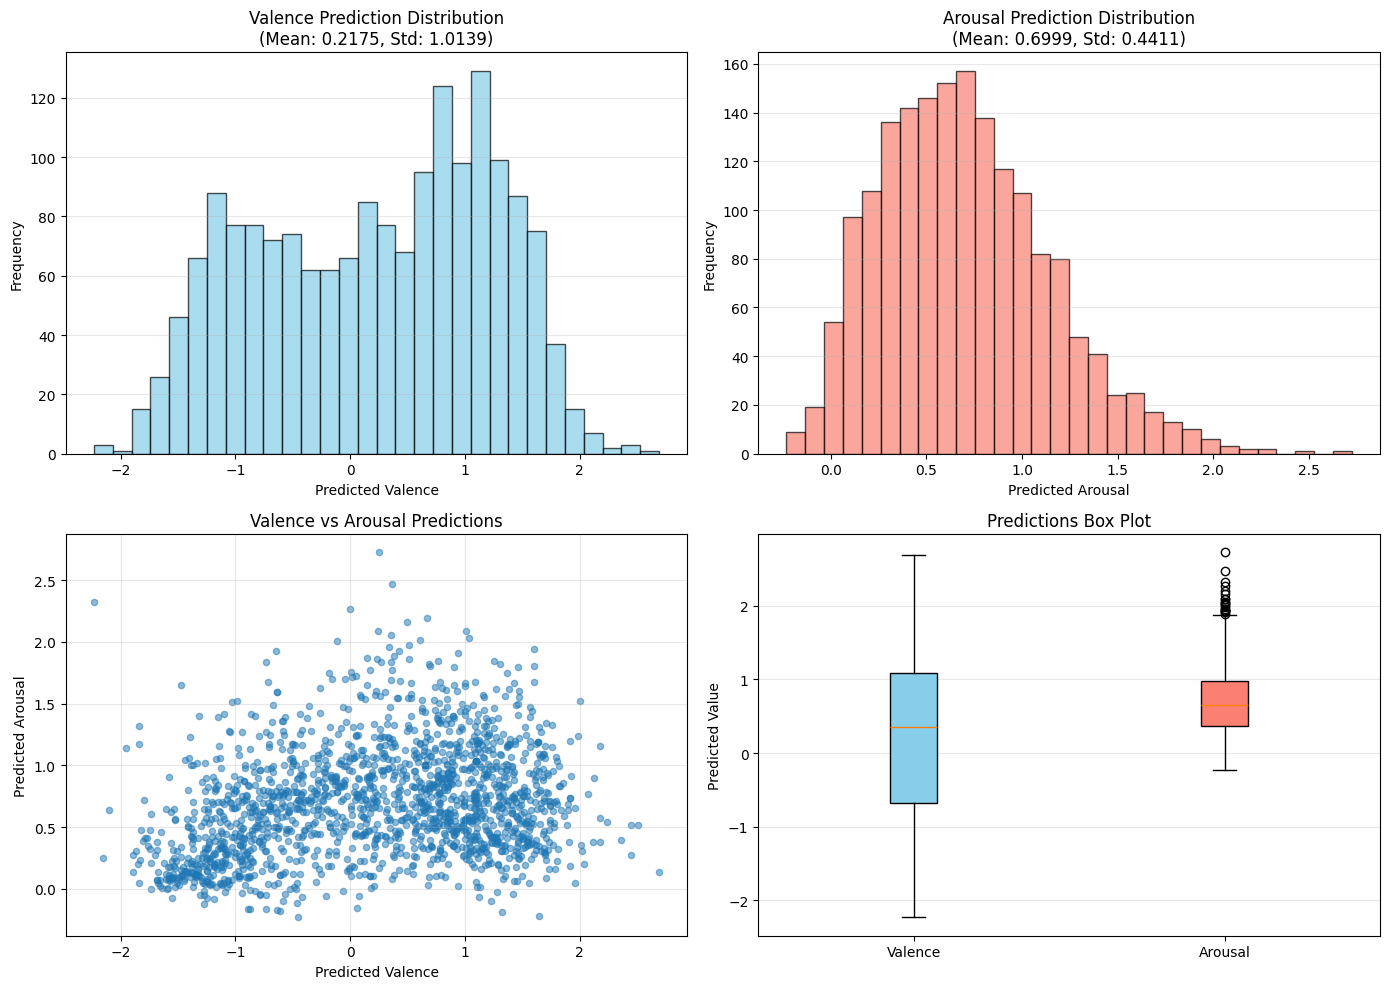


✓ Visualization saved as 'prediction_distribution.png'

Prediction Statistics:
Valence - Min: -2.2332, Max: 2.6942, Mean: 0.2175, Std: 1.0139
Arousal - Min: -0.2309, Max: 2.7231, Mean: 0.6999, Std: 0.4411


In [20]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Valence prediction distribution
axes[0, 0].hist(test_preds_np[:, 0], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('Predicted Valence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Valence Prediction Distribution\n(Mean: {test_preds_np[:, 0].mean():.4f}, Std: {test_preds_np[:, 0].std():.4f})')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Panel 2: Arousal prediction distribution
axes[0, 1].hist(test_preds_np[:, 1], bins=30, alpha=0.7, edgecolor='black', color='salmon')
axes[0, 1].set_xlabel('Predicted Arousal')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Arousal Prediction Distribution\n(Mean: {test_preds_np[:, 1].mean():.4f}, Std: {test_preds_np[:, 1].std():.4f})')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Panel 3: Scatter plot - Valence vs Arousal
axes[1, 0].scatter(test_preds_np[:, 0], test_preds_np[:, 1], alpha=0.5, s=20)
axes[1, 0].set_xlabel('Predicted Valence')
axes[1, 0].set_ylabel('Predicted Arousal')
axes[1, 0].set_title('Valence vs Arousal Predictions')
axes[1, 0].grid(True, alpha=0.3)

# Panel 4: Box plots
box_data = [test_preds_np[:, 0], test_preds_np[:, 1]]
bp = axes[1, 1].boxplot(box_data, labels=['Valence', 'Arousal'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['skyblue', 'salmon']):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Predicted Value')
axes[1, 1].set_title('Predictions Box Plot')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'prediction_distribution.png'")

# Print summary statistics
print(f"\nPrediction Statistics:")
print(f"Valence - Min: {test_preds_np[:, 0].min():.4f}, Max: {test_preds_np[:, 0].max():.4f}, Mean: {test_preds_np[:, 0].mean():.4f}, Std: {test_preds_np[:, 0].std():.4f}")
print(f"Arousal - Min: {test_preds_np[:, 1].min():.4f}, Max: {test_preds_np[:, 1].max():.4f}, Mean: {test_preds_np[:, 1].mean():.4f}, Std: {test_preds_np[:, 1].std():.4f}")


# Test Analysis

In [21]:

# ============================================================================
# ANALYSIS 1: Build test_analysis DataFrame & compute metrics
# ============================================================================
import os
from scipy.stats import pearsonr

os.makedirs('TestAnalysis', exist_ok=True)

# Load ground-truth labels
labels_df = pd.read_csv("/u50/zhanh279/SemEval-2026/TEST_RELEASE_5JAN2026/test_labels_subtask1.csv",
                        on_bad_lines='skip')

# Build analysis DataFrame from in-memory data (avoids re-reading CSV)
test_analysis = test_targets[['user_id', 'text_id']].copy()
test_analysis['is_words'] = test_LIWC['is_words'].values
test_analysis['text']     = test_LIWC['text'].values

# Merge ground-truth labels
test_analysis = test_analysis.merge(
    labels_df[['user_id', 'text_id', 'valence', 'arousal']],
    on=['user_id', 'text_id'], how='inner'
)

# Align predictions (same row order after merge — use text_id as key)
pred_df = pd.DataFrame({
    'user_id':       test_user_ids,
    'text_id':       test_targets['text_id'].values,
    'pred_valence':  test_preds_np[:, 0],
    'pred_arousal':  test_preds_np[:, 1],
})
test_analysis = test_analysis.merge(pred_df, on=['user_id', 'text_id'], how='inner')
test_analysis = test_analysis.reset_index(drop=True)

# Error columns
test_analysis['err_valence']    = test_analysis['valence']  - test_analysis['pred_valence']
test_analysis['err_arousal']    = test_analysis['arousal']  - test_analysis['pred_arousal']
test_analysis['abs_err_valence'] = test_analysis['err_valence'].abs()
test_analysis['abs_err_arousal'] = test_analysis['err_arousal'].abs()
test_analysis['performance_valence'] = test_analysis['abs_err_valence'].apply(
    lambda x: 'good' if x < 0.3 else ('medium' if x < 0.6 else 'poor')
)
test_analysis['performance_arousal'] = test_analysis['abs_err_arousal'].apply(
    lambda x: 'good' if x < 0.3 else ('medium' if x < 0.6 else 'poor')
)

# Metrics
mae_v = mean_absolute_error(test_analysis['valence'], test_analysis['pred_valence'])
mae_a = mean_absolute_error(test_analysis['arousal'], test_analysis['pred_arousal'])
r_v, p_v = pearsonr(test_analysis['valence'], test_analysis['pred_valence'])
r_a, p_a = pearsonr(test_analysis['arousal'], test_analysis['pred_arousal'])

print(f"Matched samples: {len(test_analysis)}")
print("\n" + "=" * 50)
print("TEST PERFORMANCE")
print("=" * 50)
print(f"{'Metric':<25} {'Valence':>12} {'Arousal':>12}")
print("-" * 50)
print(f"{'MAE':<25} {mae_v:>12.4f} {mae_a:>12.4f}")
print(f"{'Pearson r':<25} {r_v:>12.4f} {r_a:>12.4f}")
print(f"{'Pearson p-value':<25} {p_v:>12.4e} {p_a:>12.4e}")
print("=" * 50)

test_analysis.to_csv('TestAnalysis/test_analysis_predictions.csv', index=False)
print(f"\nSaved TestAnalysis/test_analysis_predictions.csv  ({len(test_analysis)} rows)")


Matched samples: 1737

TEST PERFORMANCE
Metric                         Valence      Arousal
--------------------------------------------------
MAE                             0.7512       0.5253
Pearson r                       0.6706       0.4933
Pearson p-value            2.9215e-227  3.3905e-107

Saved TestAnalysis/test_analysis_predictions.csv  (1737 rows)


In [22]:

# ============================================================================
# ANALYSIS 2: POS importance for arousal AND valence prediction
# ============================================================================
import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")

def get_pos_counts(text):
    doc = nlp(str(text))
    counts = defaultdict(int)
    for token in doc:
        if not token.is_space:
            counts[token.pos_] += 1
    total = max(sum(counts.values()), 1)
    return {pos: cnt / total for pos, cnt in counts.items()}

print("Computing POS features for test set (this may take ~30 seconds)...")
pos_records = [get_pos_counts(t) for t in test_analysis['text']]
pos_df = pd.DataFrame(pos_records).fillna(0)

pos_df['abs_err_arousal'] = test_analysis['abs_err_arousal'].values
pos_df['abs_err_valence'] = test_analysis['abs_err_valence'].values
pos_df['arousal']         = test_analysis['arousal'].values
pos_df['valence']         = test_analysis['valence'].values
pos_df['perf_arousal']    = test_analysis['performance_arousal'].values
pos_df['perf_valence']    = test_analysis['performance_valence'].values

meta_cols = ['abs_err_arousal','abs_err_valence','arousal','valence','perf_arousal','perf_valence']
pos_cols = [c for c in pos_df.columns if c not in meta_cols]

# --- AROUSAL ---
corr_arousal_err  = pos_df[pos_cols].corrwith(pos_df['abs_err_arousal']).sort_values(key=abs, ascending=False)
corr_arousal_true = pos_df[pos_cols].corrwith(pos_df['arousal']).sort_values(key=abs, ascending=False)
print("\n=== POS correlation with AROUSAL absolute error ===")
print(corr_arousal_err.round(4).to_string())
print("\n=== POS correlation with TRUE AROUSAL score ===")
print(corr_arousal_true.round(4).to_string())
print("\n=== Mean POS ratios: good vs poor AROUSAL predictions ===")
print(pos_df.groupby('perf_arousal')[pos_cols].mean().round(4).T.to_string())

# --- VALENCE ---
corr_valence_err  = pos_df[pos_cols].corrwith(pos_df['abs_err_valence']).sort_values(key=abs, ascending=False)
corr_valence_true = pos_df[pos_cols].corrwith(pos_df['valence']).sort_values(key=abs, ascending=False)
print("\n=== POS correlation with VALENCE absolute error ===")
print(corr_valence_err.round(4).to_string())
print("\n=== POS correlation with TRUE VALENCE score ===")
print(corr_valence_true.round(4).to_string())
print("\n=== Mean POS ratios: good vs poor VALENCE predictions ===")
print(pos_df.groupby('perf_valence')[pos_cols].mean().round(4).T.to_string())


Computing POS features for test set (this may take ~30 seconds)...

=== POS correlation with AROUSAL absolute error ===
PUNCT   -0.0863
PART     0.0861
PRON     0.0827
ADP      0.0774
AUX      0.0702
SCONJ    0.0679
ADJ     -0.0535
DET      0.0522
NOUN     0.0515
ADV      0.0495
CCONJ    0.0488
VERB     0.0406
INTJ    -0.0351
PROPN   -0.0347
X        0.0300
SYM      0.0269
NUM      0.0198

=== POS correlation with TRUE AROUSAL score ===
INTJ     0.0697
ADJ      0.0455
NUM     -0.0441
X       -0.0252
PROPN   -0.0233
PRON    -0.0230
SYM     -0.0218
VERB    -0.0216
CCONJ    0.0156
DET     -0.0146
AUX     -0.0132
PART    -0.0130
SCONJ   -0.0107
ADP     -0.0075
NOUN    -0.0051
ADV     -0.0042
PUNCT    0.0026

=== Mean POS ratios: good vs poor AROUSAL predictions ===
perf_arousal    good  medium    poor
PRON          0.0555  0.0612  0.0710
VERB          0.0819  0.0879  0.0922
ADP           0.0337  0.0374  0.0410
ADJ           0.2113  0.1937  0.1892
NOUN          0.0713  0.0728  0.0802
NUM   

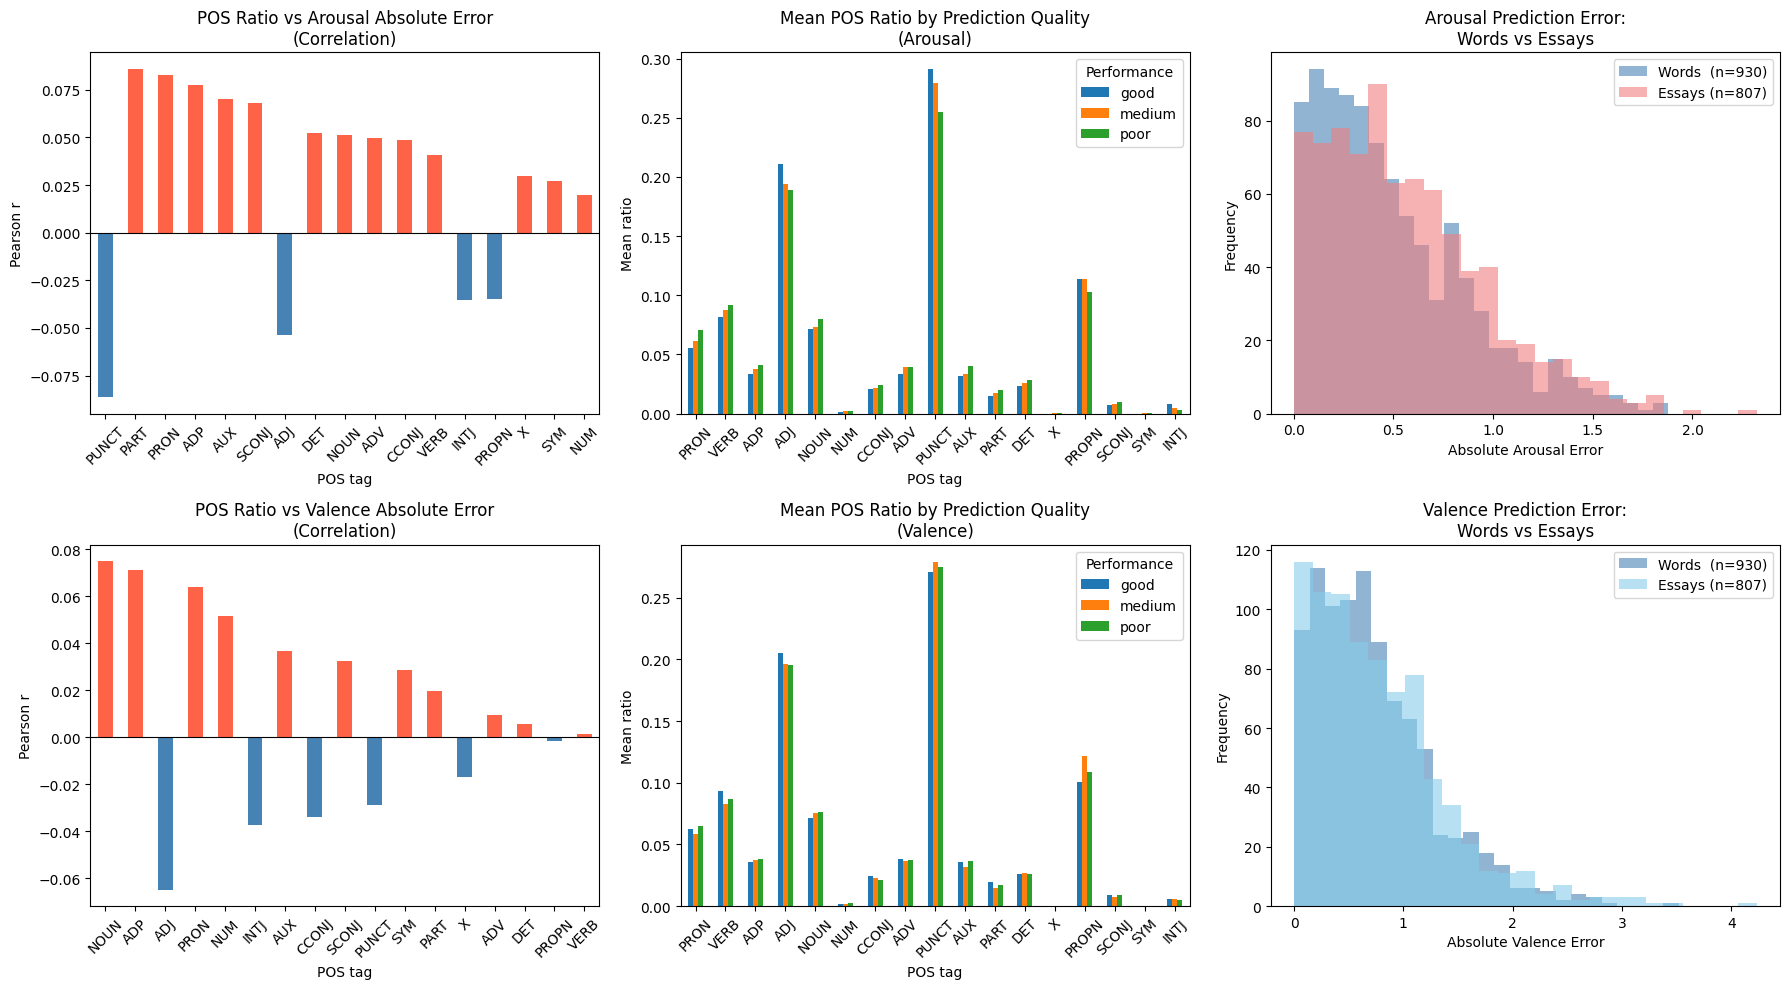

Saved TestAnalysis/test_linguistic_patterns.png
Saved TestAnalysis/test_analysis_with_pos.csv  (1737 rows, 31 cols)
Saved TestAnalysis/test_essays_summary.csv  (807 essays)


In [23]:

# ============================================================================
# ANALYSIS 3: Linguistic pattern visualisation (Arousal + Valence) + export CSV
# ============================================================================
import seaborn as sns

pos_cols_plot = pos_cols

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row, (target, err_col, perf_col, corr_err, color) in enumerate([
    ('Arousal', 'abs_err_arousal', 'perf_arousal', corr_arousal_err, 'lightcoral'),
    ('Valence', 'abs_err_valence', 'perf_valence', corr_valence_err, 'skyblue'),
]):
    # --- (a) POS correlation bar chart ---
    ax = axes[row, 0]
    corr_err.plot(kind='bar', ax=ax, color=['tomato' if v > 0 else 'steelblue' for v in corr_err])
    ax.set_title(f'POS Ratio vs {target} Absolute Error\n(Correlation)')
    ax.set_xlabel('POS tag')
    ax.set_ylabel('Pearson r')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.tick_params(axis='x', rotation=45)

    # --- (b) Mean POS ratios: good vs poor ---
    ax = axes[row, 1]
    group_means = pos_df.groupby(perf_col)[pos_cols_plot].mean().T
    group_means.plot(kind='bar', ax=ax)
    ax.set_title(f'Mean POS Ratio by Prediction Quality\n({target})')
    ax.set_xlabel('POS tag')
    ax.set_ylabel('Mean ratio')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Performance')

    # --- (c) Error distribution: words vs essays ---
    ax = axes[row, 2]
    words_e  = test_analysis[test_analysis['is_words'] == True][err_col]
    essays_e = test_analysis[test_analysis['is_words'] == False][err_col]
    ax.hist(words_e,  bins=25, alpha=0.6, label=f'Words  (n={len(words_e)})',  color='steelblue')
    ax.hist(essays_e, bins=25, alpha=0.6, label=f'Essays (n={len(essays_e)})', color=color)
    ax.set_xlabel(f'Absolute {target} Error')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{target} Prediction Error:\nWords vs Essays')
    ax.legend()

plt.tight_layout()
plt.savefig('TestAnalysis/test_linguistic_patterns.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved TestAnalysis/test_linguistic_patterns.png")

# ----- Export CSVs -----
full_export = test_analysis.copy()
for col in pos_cols_plot:
    full_export[f'pos_{col}'] = pos_df[col].values

full_export.to_csv('TestAnalysis/test_analysis_with_pos.csv', index=False)
print(f"Saved TestAnalysis/test_analysis_with_pos.csv  ({len(full_export)} rows, {len(full_export.columns)} cols)")

essays_df = full_export[full_export['is_words'] == False].copy()
essays_df['text_snippet'] = essays_df['text'].str[:60]
essays_summary = essays_df[['user_id','text_id','text_snippet',
                             'valence','arousal',
                             'pred_valence','pred_arousal',
                             'abs_err_valence','abs_err_arousal',
                             'performance_valence','performance_arousal']].sort_values('abs_err_arousal', ascending=False)
essays_summary.to_csv('TestAnalysis/test_essays_summary.csv', index=False)
print(f"Saved TestAnalysis/test_essays_summary.csv  ({len(essays_summary)} essays)")


Valence label range : [-2, 2]
Arousal label range : [0, 2]
Valence  — Accuracy (exact int match): 0.3978
Arousal  — Accuracy (exact int match): 0.5561


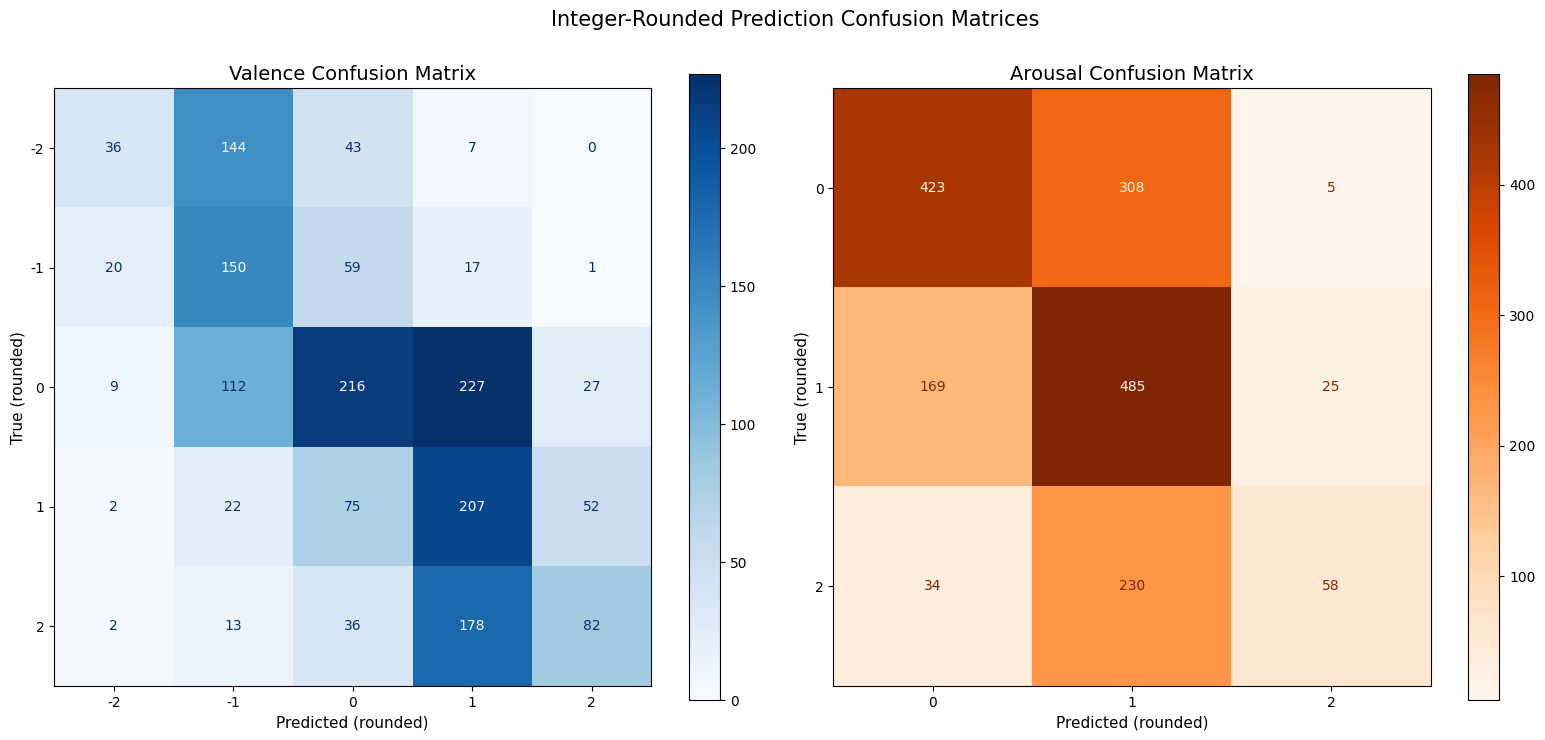

Saved TestAnalysis/test_confusion_matrices.png

=== Valence Classification Report ===
              precision    recall  f1-score   support

          -2       0.52      0.16      0.24       230
          -1       0.34      0.61      0.44       247
           0       0.50      0.37      0.42       591
           1       0.33      0.58      0.42       358
           2       0.51      0.26      0.35       311

    accuracy                           0.40      1737
   macro avg       0.44      0.39      0.37      1737
weighted avg       0.45      0.40      0.39      1737

=== Arousal Classification Report ===
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       736
           1       0.47      0.71      0.57       679
           2       0.66      0.18      0.28       322

    accuracy                           0.56      1737
   macro avg       0.60      0.49      0.49      1737
weighted avg       0.59      0.56      0.54      1737

Update

In [24]:

# ============================================================================
# ANALYSIS 4: Round predictions to integers & Confusion Matrices
# ============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Round and clip predictions to integer labels (per dimension) ---
true_valence  = test_analysis['valence'].round().astype(int).values
true_arousal  = test_analysis['arousal'].round().astype(int).values

# Use per-dimension label ranges to avoid spurious empty rows
v_min, v_max = int(true_valence.min()), int(true_valence.max())
a_min, a_max = int(true_arousal.min()), int(true_arousal.max())

pred_valence_int = np.clip(np.round(test_analysis['pred_valence'].values).astype(int), v_min, v_max)
pred_arousal_int = np.clip(np.round(test_analysis['pred_arousal'].values).astype(int), a_min, a_max)

print(f"Valence label range : [{v_min}, {v_max}]")
print(f"Arousal label range : [{a_min}, {a_max}]")
print(f"Valence  — Accuracy (exact int match): {(pred_valence_int == true_valence).mean():.4f}")
print(f"Arousal  — Accuracy (exact int match): {(pred_arousal_int == true_arousal).mean():.4f}")

# --- Confusion Matrices ---
labels_v = list(range(v_min, v_max + 1))
labels_a = list(range(a_min, a_max + 1))

cm_v = confusion_matrix(true_valence,  pred_valence_int,  labels=labels_v)
cm_a = confusion_matrix(true_arousal,  pred_arousal_int,  labels=labels_a)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, cm, title, cmap, lbls in [
    (axes[0], cm_v, 'Valence Confusion Matrix',  'Blues',   labels_v),
    (axes[1], cm_a, 'Arousal Confusion Matrix',  'Oranges', labels_a),
]:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
    disp.plot(ax=ax, colorbar=True, cmap=cmap, values_format='d')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted (rounded)', fontsize=11)
    ax.set_ylabel('True (rounded)', fontsize=11)

plt.suptitle('Integer-Rounded Prediction Confusion Matrices', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('TestAnalysis/test_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved TestAnalysis/test_confusion_matrices.png")

# --- Per-class report ---
print("\n=== Valence Classification Report ===")
print(classification_report(true_valence, pred_valence_int, labels=labels_v, zero_division=0))
print("=== Arousal Classification Report ===")
print(classification_report(true_arousal, pred_arousal_int, labels=labels_a, zero_division=0))

# --- Save integer predictions to CSV ---
test_analysis['pred_valence_int'] = pred_valence_int
test_analysis['pred_arousal_int'] = pred_arousal_int
test_analysis.to_csv('TestAnalysis/test_analysis_predictions.csv', index=False)
print("Updated TestAnalysis/test_analysis_predictions.csv with integer prediction columns.")
